# Laser calibration

In this article is presented the laser calibration process. This method is used to determine the position and orientation of a line laser, respect to the camera coordinate system. ![](https://raw.githubusercontent.com/Jesus89/3DScanScience/master/notebooks/images/4.4.%20Laser%20calibration/pattern-position.png)

## Capture laser point cloud

Pattern is automatically moved on the turntable from -90º to 90º respect to the initial position. Each step (5º) it is captured a point cloud of the laser ([Laser segmentation](http://nbviewer.ipython.org/github/Jesus89/3DScanScience/blob/master/notebooks/3.%20Laser%20segmentation.ipynb)) intersecting with the plane of the pattern ([Point cloud generation](http://nbviewer.ipython.org/github/Jesus89/3DScanScience/blob/master/notebooks/6.%20Point%20cloud%20generation.ipynb)). It is used the normal and minimum distance of the plane defined by the pattern. This values are obtained using the pattern pose ([Pattern detection](http://nbviewer.ipython.org/github/Jesus89/3DScanScience/blob/master/notebooks/4.1.%20Pattern%20detection.ipynb)).

At the end of the capture process, a complete point cloud of the laser is obtained. All points in this point cloud are near to the real laser plane. Therefore, this point cloud will be used to determine the plane parameters: the normal vector and the minimum distance respect to the camera coordinate system.

In [1]:
%matplotlib inline

from util import *

# Load point cloud
X = load_ply('laser-pc.ply').vertexes

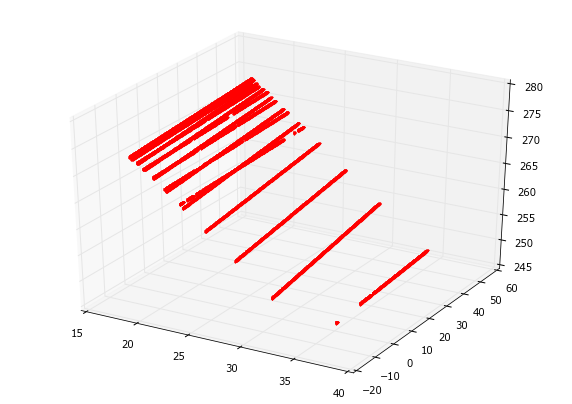

In [2]:
# Plot point cloud
pylab.rcParams['figure.figsize'] = (10, 7)
plt.gca(projection='3d')

plt.plot(X[:,0], X[:,1], X[:,2], '.r')
plt.show()

## Fit laser plane

In order to fit a plane from a point cloud $\textbf{X}$, SVD (Singular Value Decomposition) can be used. This method provides a fast way to obtain the normal $\textbf{n}$ and the distance $d$.

$$
\textbf{X}_i = \begin{bmatrix} x_i \\ y_i \\ z_i \\ \end{bmatrix}
\:\:\:\:\:\:\:\:\:\:
\overline{\textbf{X}} = \frac{1}{n}{\sum{\textbf{X}_i}}
\:\:\:\:\:\:\:\:\:\:
\widetilde{\textbf{X}_i} = \textbf{X}_i - \overline{\textbf{X}}
\:\:\:\:\:\:\:\:\:\:
M = \begin{bmatrix} \widetilde{\textbf{X}_1} \: ... \: \widetilde{\textbf{X}_i} \: ... \: \end{bmatrix}
$$

### Problem
$$
min \: M^T \textbf{n}
\:\:\:\:\:\:
\| \textbf{n} \| = 1
$$
### Solution
$$
M = USV^T
\:\:\:\:\:\:
\textbf{n} = U \begin{bmatrix} 0 \\ 0 \\ 1 \\ \end{bmatrix}
\:\:\:\:\:\:
d = \textbf{n} \: \overline{\textbf{X}}
$$

In [3]:
# import numpy.linalg
from scipy.sparse import linalg

def compute_pc(name):
    # Load point cloud
    X = load_ply(name).vertexes

    n = X.shape[0]
    Xm = X.sum(axis=0) / n
    M = np.array(X - Xm).T
    
    # Equivalent to:
    #  numpy.linalg.svd(M)[0][:,2]
    # But 1200x times faster for large point clouds
    U = linalg.svds(M, k=2)[0]
    normal = np.cross(U.T[0], U.T[1])
    if normal[2] < 0:
        normal *= -1

    dist = np.dot(normal, Xm)
    std = np.dot(M.T, normal).std()

    print("\nNormal vector\n\n{0}\n".format(normal))
    print("\nPlane distance\n\n{0} mm\n".format(dist))
    print("\nStandard deviation\n\n{0} mm\n".format(std))
    
compute_pc('laser-pc.ply')


Normal vector

[ 0.85110861 -0.00122944  0.52498829]


Plane distance

159.526931763 mm


Standard deviation

0.0884132683277 mm



### RANSAC
Random sample consensus is used to choose the best points that fits the plane with the minimum error.

In [4]:
# import numpy.linalg
from scipy.sparse import linalg

class PlaneDetection(object):

    def fit(self, X):
        M, Xm = self._compute_m(X)
        U = linalg.svds(M, k=2)[0]
        normal = np.cross(U.T[0], U.T[1])
        # normal = numpy.linalg.svd(M)[0][:,2]
        if normal[2] < 0:
            normal *= -1
        dist = np.dot(normal, Xm)
        return dist, normal, M

    def residuals(self, model, X):
        _, normal, _ = model
        M, Xm = self._compute_m(X)
        return np.abs(np.dot(M.T, normal))

    def is_degenerate(self, sample):
        return False
    
    def _compute_m(self, X):
        n = X.shape[0]
        Xm = X.sum(axis=0) / n
        M = np.array(X - Xm).T
        return M, Xm

def ransac(data, model_class, min_samples, threshold, max_trials=500):
    best_model = None
    best_inlier_num = 0
    best_inliers = None
    data_idx = np.arange(data.shape[0])
    for _ in xrange(max_trials):
        sample = data[np.random.randint(0, data.shape[0], 3)]
        if model_class.is_degenerate(sample):
            continue
        sample_model = model_class.fit(sample)
        sample_model_residua = model_class.residuals(sample_model, data)
        sample_model_inliers = data_idx[sample_model_residua < threshold]
        inlier_num = sample_model_inliers.shape[0]
        if inlier_num > best_inlier_num:
            best_inlier_num = inlier_num
            best_inliers = sample_model_inliers
    if best_inliers is not None:
        best_model = model_class.fit(data[best_inliers])
    return best_model, best_inliers

In [5]:
def compute_ransac_pc(name):
    # Load point cloud
    X = load_ply(name).vertexes

    model, inliers = ransac(X, PlaneDetection(), 3, 0.1)
    
    dist, normal, M = model
    std = np.dot(M.T, normal).std()
    
    print("\nNormal vector\n\n{0}\n".format(normal))
    print("\nPlane distance\n\n{0} mm\n".format(dist))
    print("\nStandard deviation\n\n{0} mm\n".format(std))
    
compute_ransac_pc('laser-pc.ply')


Normal vector

[ 0.84936136 -0.00132746  0.5278101 ]


Plane distance

160.235092163 mm


Standard deviation

0.0539078749716 mm



## References
* http://www.ltu.se/cms_fs/1.51590!/svd-fitting.pdf
* https://github.com/ahojnnes/numpy-snippets/blob/master/ransac.py